In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import collections
import seaborn as sns
from pathlib import Path

In [2]:
# custom helper functions
#import carbohydrate_helpers as carbo
#import plot_helpers as plot

from src.analysis import annotation_helpers as helpers
from src.analysis.levels_heatmap import levels_heatmap
from src.config import data_dir

results = data_dir / 'processed'

# Import data tables

Relevant tables are generated using a combination of automatic assignment and manual refinement. See `cazyme-data-tables.ipynb` for code and instructions on how to generate the tables used here.

Tables
- `sb_bonds_df`: manually annotated table of bonds targeted by GH and PL with categories based on activity (i.e. glycosidase)
- `sb_subs_df`: manually annotated table of substrates targeted by GH and PL with categories based on substrate type (i.e. alpha-glucan) and a size column used to filter oligosaccharides, polysaccharides, and glycosides.
- `combined_cazyfam_df`: table of cazyme families in which each row represents a set of genes in the same family (given by the `family` column) in a given MAG (given by the `accession` column).

# 1. Import data tables
Relevant tables are generated by using the `make data` command from the root directoy. See `/src/data/` for code involved in processing data.

## Tables
* `cazyme_df`: the "master table" containing all relevant information on cazyme activity, distribution, and count across the MAGs. Each row represents a gene family (indicated by the `family` column) in a given MAG (indicated by the `accession`) column. The count of extracellular and total genes belonging to the relevant family in the given MAG is given, alongside metadata/annotations on the cazyme activity and substrate predicted based on EC numbers and CAZydb annotations.
* `metadata`: the processed metadata table. MAGs appear in order based on a combination of phylum-level taxonomy and alphabetic grouping.


In [3]:
cazyme_df = pd.read_table(Path(results / 'CAZyme_table.tsv'), index_col=0).reset_index()
metadata = pd.read_table(Path(data_dir / 'processed' / 'metadata.tsv'), index_col=0).reset_index()
bonds_df = pd.read_table(Path(data_dir / 'raw' / 'final_manual_annos' / 'bond_targets_inMAGs_categories.tsv'))
subs_df = pd.read_table(Path(data_dir / 'raw' / 'final_manual_annos' / 'substrates_inMAGs_categories.tsv'))

# Find polyspecificity cutoffs for GH/PL bond targets. 

Some CAZyme families are highly polyspecific, and when abundant, these families can overwhelm the patterns present in the more specific families. Here, I make histograms of the number of genes with an activity in each activity/substrate category with increasingly relaxed cutoffs for exclusion of polyspecific families. This helps me determine the optimum number of categories-per-gene to use as a cutoff for exclusion of polyspecific families.

## Cutoffs results
Based on the plots, I set the cutoffs as:
- 3 or fewer bond-based activity categories when analyzing based on `cat1`
- 8 or fewer substrate-based categories when analyzing based on `cat`

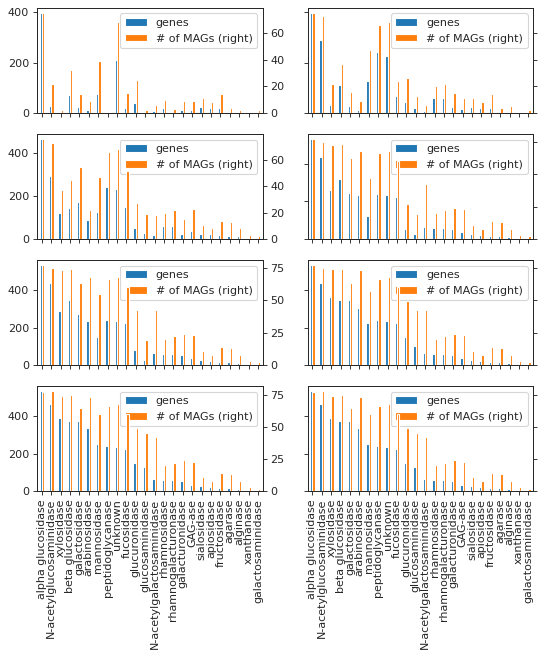

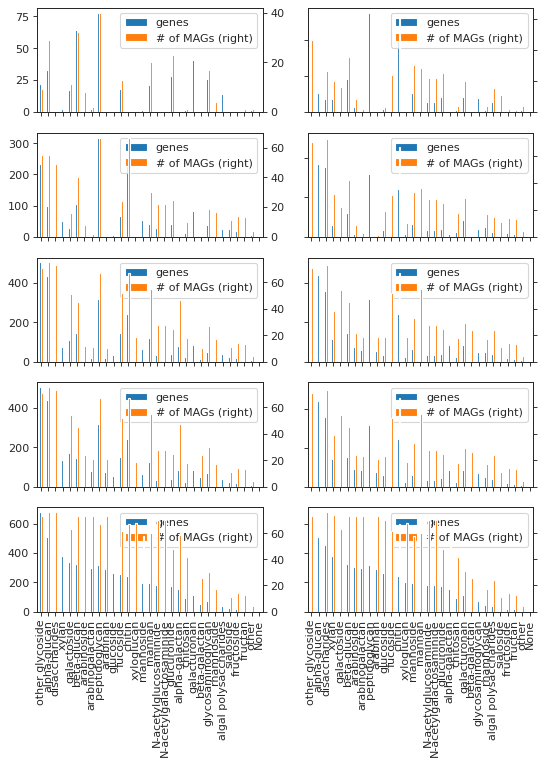

In [4]:
ghpl_df = cazyme_df[cazyme_df['family'].str.contains('GH|PL')]

sns.set_style("ticks")

# get the order for the categories based on descending abundance with no genes excluded 
cat_dict = helpers.get_cat_dict(100, bonds_df, ghpl_df)
cat = pd.DataFrame.from_dict(cat_dict, orient='index', columns=['genes','# MAGs']).sort_values('genes', ascending=False)
set_index = cat.index

# plot charts for increasingly high cutoffs for polyspecificity 
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(8,8), dpi=80)
axs = axs.ravel()
exclude_length = 1
for a in axs:
    cat_dict = helpers.get_cat_dict(exclude_length, bonds_df, ghpl_df)
    cat = pd.DataFrame.from_dict(cat_dict, orient='index', columns=['genes','# of MAGs']).reindex(set_index)
    cat.plot(kind= 'bar' , secondary_y= '# of MAGs' , rot= 90, ax=a, sharex=True, sharey=True)
    exclude_length += 1
    

    
# get the order for the categories based on descending abundance with no genes excluded 
cat_dict = helpers.get_cat_dict(1000, subs_df, ghpl_df)
cat = pd.DataFrame.from_dict(cat_dict, orient='index', columns=['genes','# MAGs']).sort_values('genes', ascending=False)
set_index = cat.index

    
# plot charts for increasingly high cutoffs for polyspecificity 
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(8,10), dpi=80)
axs = axs.ravel()
exclude_length = 1
for a in axs:
    cat_dict = helpers.get_cat_dict(exclude_length, subs_df, ghpl_df)
    cat = pd.DataFrame.from_dict(cat_dict, orient='index', columns=['genes','# of MAGs']).reindex(set_index)
    cat.plot(kind= 'bar' , secondary_y= '# of MAGs' , rot= 90, ax=a, sharex=True, sharey=True)
    exclude_length += 1

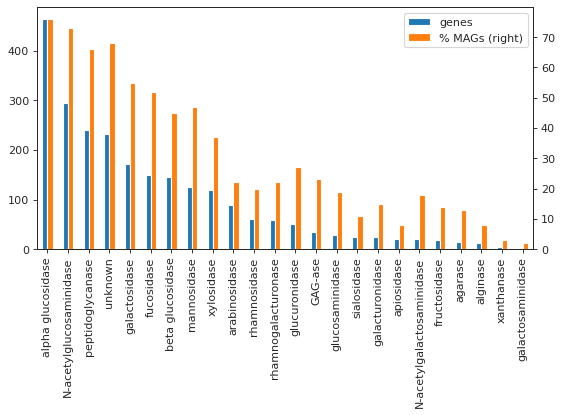

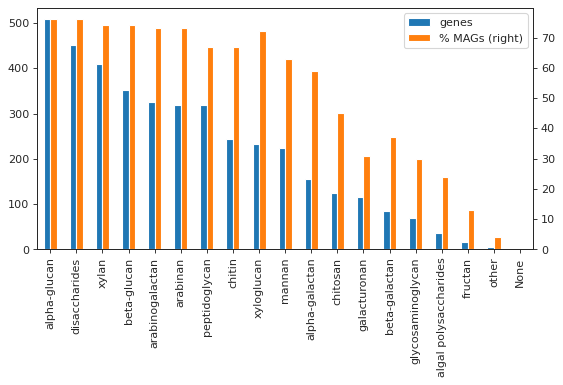

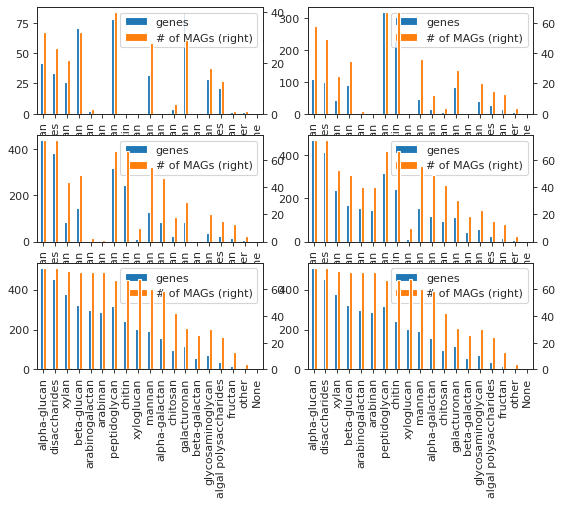

In [5]:
# plot with the favored cutoff for polyspecificity
fig = plt.figure(figsize=(8,4), dpi=80)
cat_dict = helpers.get_cat_dict(3, bonds_df, ghpl_df)
cat = pd.DataFrame.from_dict(cat_dict, orient='index', columns=['genes','% MAGs']).sort_values('genes', ascending=False)
cat.plot(kind= 'bar' , secondary_y= '% MAGs' , rot= 90, ax = plt.gca())
set_index = cat.index


# plot with the favored cutoff for polyspecificity
fig = plt.figure(figsize=(8,4), dpi=80)
cat_dict = helpers.get_cat_dict(8, subs_df[subs_df['size'] != 'glycoside'], ghpl_df)
cat = pd.DataFrame.from_dict(cat_dict, orient='index', columns=['genes','% MAGs']).sort_values('genes', ascending=False)
cat.plot(kind= 'bar' , secondary_y= '% MAGs' , rot= 90, ax = plt.gca())

set_index = cat.index

# plot charts for increasingly high cutoffs for polyspecificity 
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8,6), dpi=80)
axs = axs.ravel()
exclude_length = 1
for a in axs:
    cat_dict = helpers.get_cat_dict(exclude_length, subs_df[subs_df['size'] != 'glycoside'], ghpl_df)
    cat = pd.DataFrame.from_dict(cat_dict, orient='index', columns=['genes','# of MAGs']).reindex(set_index)
    cat.plot(kind= 'bar' , secondary_y= '# of MAGs' , rot= 90, ax=a)
    exclude_length += 1

# Fucanases and fucosidases

Fucan/fucoidan degradation requires hundreds of enzymes. Some verrucomicrobia are known to degrade it. Let's see who can degrade fucan?

### Result: fucanases are restricted to two Planctomycetes but fucosidases are widespread

In [6]:
fucan_accs = cazyme_df[cazyme_df['substrate cat2'].str.contains('fucan') == True]['accession']
fucoside_accs = cazyme_df[cazyme_df['activity cat1'].str.contains('fucosidase') == True]['accession']
print('Phyla with a fucan or fucoside-targeting CAZyme')
print(set(metadata[metadata['taxon_oid'].isin(fucoside_accs)]['Phylum']))
print()
print('MAGs with a fucan-targeting CAZyme')
metadata[metadata['taxon_oid'].isin(fucan_accs)]

Phyla with a fucan or fucoside-targeting CAZyme
{'Ca. Hydrogenedentes', 'Chloroflexi', 'Planctomycetes', 'Cyanobacteria', 'Gammaproteobacteria', 'Bacteroidetes', 'BRC1', 'Myxococcota', 'Verrucomicrobia', 'Alphaproteobacteria'}

MAGs with a fucan-targeting CAZyme


,index,taxon_oid,Domain,Sequencing Status,Study Name,Genome Name / Sample Name,Sequencing Center,IMG Genome ID,Phylum,Class,Order,Family,Genus,Genome Size * assembled,Gene Count * assembled,MAG_no,shortname
40,32,2808607000,Bacteria,Permanent Draft,Coastal marine microbial mats from various loc...,Blastopirellula sp. SB-MAG 60,Massachusetts Institute of Technology,2808607000,Planctomycetes,Planctomycetia,Pirellulales,Pirellulaceae,Blastopirellula,6031763,5237,MAG 60,Planctomycetes MAG 60
48,59,2808607006,Bacteria,Permanent Draft,Coastal marine microbial mats from various loc...,Planctomycetes bacterium SB-MAG 38,Massachusetts Institute of Technology,2808607006,Planctomycetes,unclassified,unclassified,unclassified,unclassified,4510632,3832,MAG 38,Planctomycetes MAG 38


### Result: all Verrucomicrobia have fucosidases, but almost none of them are extracellular and none are specific for fucan only

In [7]:
verruco_accs = metadata[metadata['Phylum'] == 'Verrucomicrobia']['taxon_oid']
print('Number of verrucos with a fucosidase (7 total verruco MAGs): ' + str(len(verruco_accs)))
verruco_fucosidases = cazyme_df[cazyme_df['accession'].isin(verruco_accs) & (cazyme_df['activity cat1'].str.contains('fucosidase'))]
print('Extracellular verruco fucosidases: ' + str(verruco_fucosidases['ex_count'].sum()))
print('Total verruco fucosidases: ' + str(verruco_fucosidases['count'].sum()))

Number of verrucos with a fucosidase (7 total verruco MAGs): 7
Extracellular verruco fucosidases: 2
Total verruco fucosidases: 35


# Polysaccharide Lyases (PL)

* How many PL are there in the dataset?
* How many different PL activities and families?
* How are PLs distributed across the MAGs?

More specific analysis (i.e. to answer questions about specific MAGs, genes, etc) was carried out using the dataframes generated here. But since that was a lot of throwaway code just for looking through the dataframes and not for generating them or making plots, I thought it was best to remove it.


## What substrates do PLs target?
Genes with more than one substrate are counted more than once (once for each substrate). 

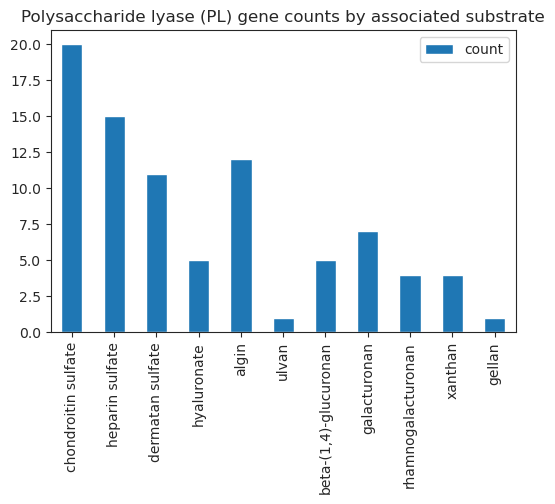

In [8]:
# get subset of cazyfam and combined cazymes dfs that are PL only
PL_combined = cazyme_df[cazyme_df['family'].str.contains('PL')]

substrate_order = ['chondroitin sulfate', 'heparin sulfate', 'dermatan sulfate', 'hyaluronate', 
                   'algin', 'ulvan', 'beta-(1,4)-glucuronan','galacturonan', 'rhamnogalacturonan', 'xanthan', 'gellan']

substrate_counter = collections.Counter(sum(PL_combined['substrates'].apply(helpers.get_strlist)*PL_combined['count'], []))

# combine algin and oligoalgin and rhamnogalacturonan and rhamnogalacturonan
algin_overlaps = PL_combined[PL_combined['substrates'].str.count('algin') > 1]['count'].sum()
substrate_counter['algin'] = substrate_counter['algin'] + substrate_counter['oligoalgin'] - algin_overlaps
substrate_counter.pop('oligoalgin')
rhamnogalacturonan_overlaps = PL_combined[PL_combined['substrates'].str.count('rhamnogalacturonan') > 1]['count'].sum()
substrate_counter['rhamnogalacturonan'] = substrate_counter['rhamnogalacturonan'] + substrate_counter['oligorhamnogalacturonan'] - rhamnogalacturonan_overlaps
substrate_counter.pop('oligorhamnogalacturonan')

# type of bonds
plt.figure(figsize=(6,4), dpi=100)
pd.DataFrame.from_dict(substrate_counter, columns=['count'], orient='index').reindex(substrate_order).plot(kind='bar', ax=plt.gca())
plt.title('Polysaccharide lyase (PL) gene counts by associated substrate')
plt.show()

## What MAGs have PLs targeting which substrates?
Heat map

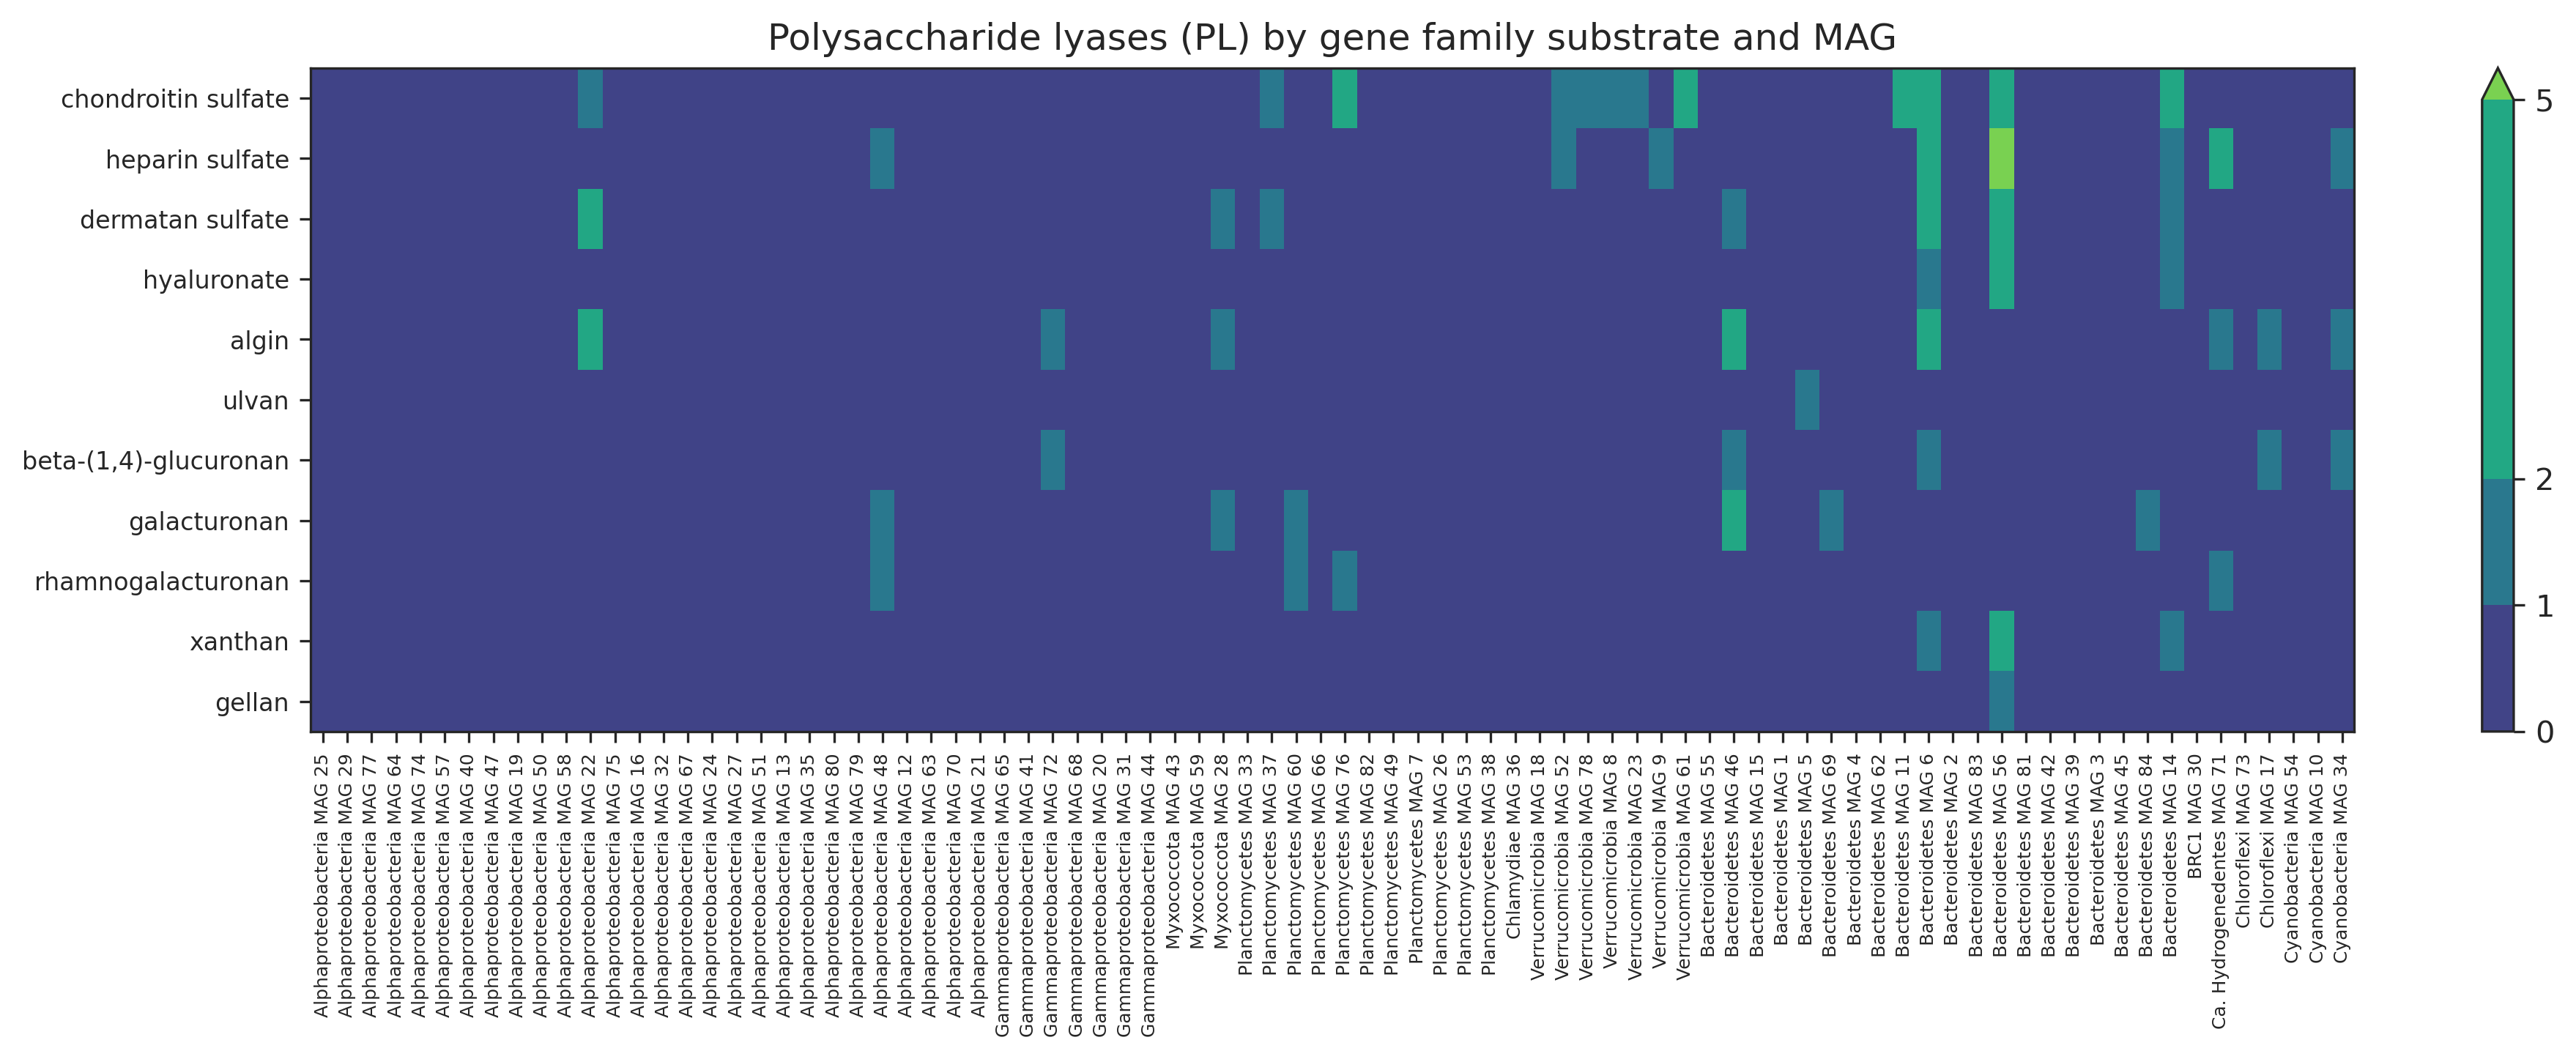

In [9]:
substrate_counts = dict.fromkeys(metadata['taxon_oid'])

for magid in substrate_counts.keys():
    substrate_counts[magid] = dict.fromkeys(substrate_order)
    mag_subset = PL_combined[PL_combined['accession'] == magid]
    for substrate in substrate_order:
        rows = helpers.get_rows_from_substrate(substrate, mag_subset)
        if len(rows) == 0:
            substrate_counts[magid][substrate] = 0
        else:
            substrate_counts[magid][substrate] = rows['count'].sum()
        
PL_substrate_vs_mag = pd.DataFrame.from_dict(substrate_counts, orient='index') 

# plot the heatmap
fig, ax = levels_heatmap([0,1,2,5], PL_substrate_vs_mag.T, figsize=(15, 4), dpi=300, palette='viridis')
plt.xticks(fontsize=6)
plt.yticks(fontsize=8)

#  rename side labels
ax.set_xticklabels(metadata['shortname'])

plt.title('Polysaccharide lyases (PL) by gene family substrate and MAG')
plt.show()

### How many genes target algal, glycosaminoglycan, and pectic polysaccharides?

In [10]:
algal = helpers.get_rows_from_substrate_list(['algin', 'ulvan', 'beta-(1,4)-glucuronan'], PL_combined)
gags = helpers.get_rows_from_substrate_list(['chondroitin sulfate', 'heparin sulfate', 'dermatan sulfate', 'hyaluronate'], PL_combined)
pectic = helpers.get_rows_from_substrate_list(['galacturonan', 'rhamnogalacturonan'], PL_combined)
bact = helpers.get_rows_from_substrate_list(['xanthan', 'gellan'], PL_combined)


print('algal PLs: ' + str(algal['count'].sum()) + ' ex_count: ' + str(algal['ex_count'].sum()) )
print('gag PLs: ' + str(gags['count'].sum()) + ' ex_count: ' + str(gags['ex_count'].sum()) )
print('pectic PLs: ' + str(pectic['count'].sum()) + ' ex_count: ' + str(pectic['ex_count'].sum()) )
print('bact PLs: ' + str(bact['count'].sum()) + ' ex_count: ' + str(bact['ex_count'].sum()) )

algal PLs: 13 ex_count: 13
gag PLs: 35 ex_count: 23
pectic PLs: 9 ex_count: 7
bact PLs: 5 ex_count: 3


# Analysis of glycoside hydrolases (GH)
* How many GHs are there in the dataset?
* How many families of GHs are there in the dataset?
* what bonds do they target?
    * Phylum-level pattern
* what substrates do they target?

In [11]:
GH_df = cazyme_df[cazyme_df['family'].str.contains('GH')]
# number of total and extracellular GH
print('total GH: ' + str(GH_df['count'].sum()))
print('extracellular GH: ' + str(GH_df['ex_count'].sum()))
print('total CAZymes: ' + str(cazyme_df['count'].sum()))
print('extracelluar CAZymes: ' + str(cazyme_df['ex_count'].sum()))
print()
print('GH families: ' + str(len(set(GH_df['family']))))
print('GH ex_families: ' + str(len(set(GH_df[GH_df['ex_count'] > 0]['family']))))
print('total families: ' + str(len(set(cazyme_df['family']))))
print('ex_families: ' + str(len(set(cazyme_df[cazyme_df['ex_count'] > 0]['family']))))

total GH: 1972
extracellular GH: 945
total CAZymes: 4654
extracelluar CAZymes: 1323

GH families: 96
GH ex_families: 74
total families: 181
ex_families: 137


In [12]:
def get_sample_list(col, df, exclude_threshold=None, count_col='count'):
    if exclude_threshold == None:
        return(sum(df[col].apply(helpers.get_strlist)*df[count_col], []))
    else: 
        # the number of ; is 1 less than the number of items 
        filtered_rows = df[df[col].str.count('; ') < exclude_threshold]
        return(sum(filtered_rows[col].apply(helpers.get_strlist)*filtered_rows[count_col], []))

# make matrix of activities to turn into heat map.
# row = MAG
# column = counts of genes with that activity

activity_matrix_dict = dict.fromkeys(metadata['taxon_oid'])

for magid in activity_matrix_dict.keys():
    activity_matrix_dict[magid] = dict.fromkeys(set(get_sample_list('activity cat1', GH_df)), 0)
    mag_GH = GH_df[GH_df['accession'] == magid]
    mag_category_counts = collections.Counter(get_sample_list('activity cat1', mag_GH))
    
    for activity in activity_matrix_dict[magid].keys():
        if activity in mag_category_counts.keys():
            activity_matrix_dict[magid][activity] = mag_category_counts[activity]


activity_matrix = pd.DataFrame.from_dict(activity_matrix_dict, orient='index')
set(activity_matrix['GAG-ase'])

{0, 1, 2}

## Notes on activity categories
Activity categories were defined either by the bond targeted or by the substrate associated with the bond. The latter was the case especially when the bond targeted was between two different sugars (for instance, peptidoglycanase cleaving the bond between N-acetylglucosamine and N-acetylmuramate. Examples of substrate-associated assigments are alginases, rhamnogalacturonases, 

### Refining categories for analysis
Not all of the categories are interesting. For instance, other glycosidase is not super interesting to show on plots. I can simply report that 210 genes had some kind of glycosidase activity that wasn't well-defined.

Refinements to make:
change "other glycosidase" to "unknown glycosidase"
bin the following:
- 


In [13]:
collections.Counter(activity_matrix['GAG-ase'])

Counter({0: 72, 1: 11, 2: 1})

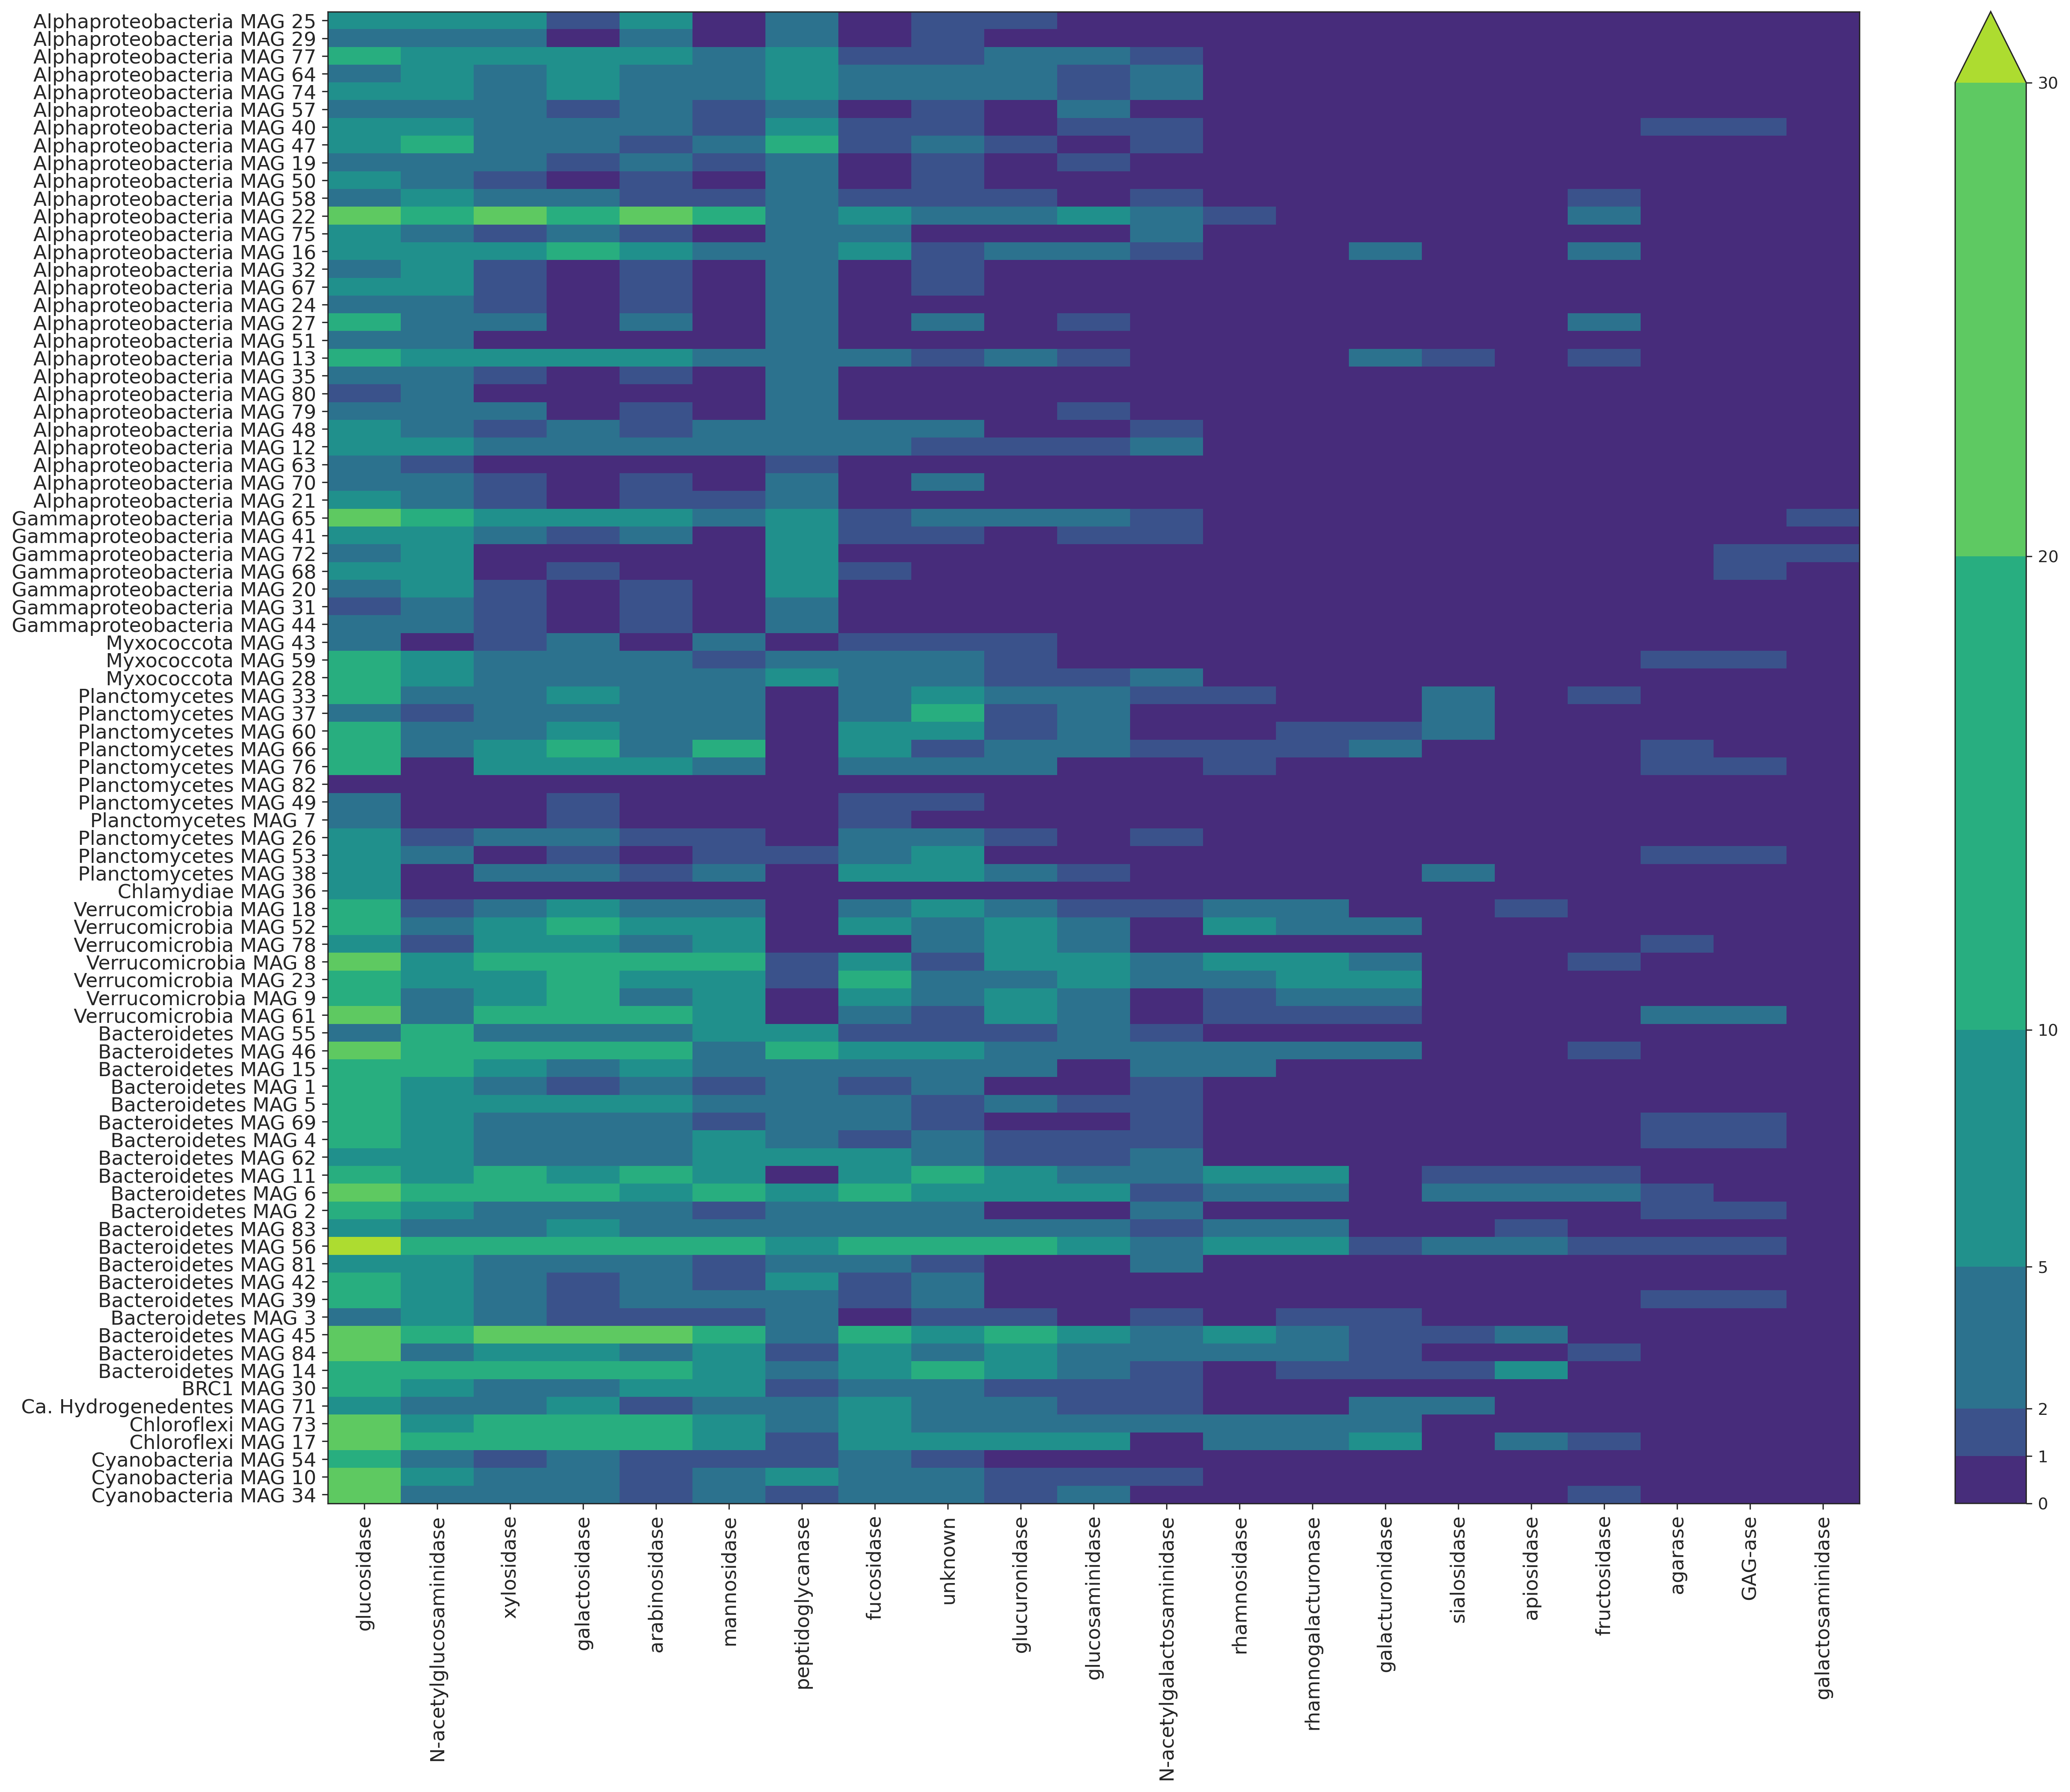

In [14]:
activity_matrix = pd.DataFrame.from_dict(activity_matrix_dict, orient='index').reindex(metadata['taxon_oid'].tolist())
cols = activity_matrix.sum().sort_values(ascending=False).index
activity_matrix = activity_matrix[cols]
fig, ax = levels_heatmap([0,1,2,5,10,20,30], activity_matrix, extend='max', figsize=(activity_matrix.shape[1],activity_matrix.shape[0]/5), dpi=300, palette='viridis')
ax.set_yticklabels(metadata['shortname'])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [15]:
activity_matrix_dict = dict.fromkeys(metadata['taxon_oid'])

for magid in activity_matrix_dict.keys():
    activity_matrix_dict[magid] = dict.fromkeys(set(get_sample_list('activity cat1', GH_df)), 0)
    mag_GH = GH_df[GH_df['accession'] == magid]
    mag_category_counts = collections.Counter(get_sample_list('activity cat1', mag_GH, exclude_threshold=3))
    
    for activity in activity_matrix_dict[magid].keys():
        if activity in mag_category_counts.keys():
            activity_matrix_dict[magid][activity] = mag_category_counts[activity]


activity_matrix = pd.DataFrame.from_dict(activity_matrix_dict, orient='index')
set(activity_matrix['GAG-ase'])

{0, 1, 2}

In [16]:
activity_matrix = pd.DataFrame.from_dict(activity_matrix_dict, orient='index').reindex(metadata['taxon_oid'].tolist())
cols = activity_matrix.sum().sort_values(ascending=False).index
activity_matrix = activity_matrix[cols]
fig, ax = plot.levels_heatmap([0,1,2,5,10,20,30], activity_matrix, extend='max', figsize=(activity_matrix.shape[1],activity_matrix.shape[0]/5), dpi=300, palette='viridis')
ax.set_yticklabels(metadata['shortname'])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

NameError: name 'plot' is not defined

## Substrate-based heatmaps
* separate ones for glycosides and carbohydrates

In [ ]:
glycoside_names = set(subs_df[subs_df['size'] == 'glycoside']['cat1'])
glycoside_names = [x for x in glycoside_names if str(x) != 'nan'] # remove nan

carbohydrate_names = set(subs_df[subs_df['size'] != 'glycoside']['cat1'])
carbohydrate_names = [x for x in carbohydrate_names if str(x) != 'nan']
carbohydrate_names.remove('disaccharides')
carbohydrate_names.remove('other')

carbo_matrix_dict = dict.fromkeys(metadata['taxon_oid'])
for magid in carbo_matrix_dict.keys():
    carbo_matrix_dict[magid] = dict.fromkeys(carbohydrate_names, 0)
    mag_GH = GH_df[GH_df['accession'] == magid]
    mag_category_counts = collections.Counter(get_sample_list('substrate cat1', mag_GH))
    
    for sub in carbo_matrix_dict[magid].keys():
        if sub in mag_category_counts.keys():
            carbo_matrix_dict[magid][sub] = mag_category_counts[sub]


carbo_matrix = pd.DataFrame.from_dict(carbo_matrix_dict, orient='index').reindex(metadata['taxon_oid'].tolist())
cols = carbo_matrix.sum().sort_values(ascending=False).index
carbo_matrix = carbo_matrix[cols]
fig, ax = levels_heatmap([0,1,2,5,10,20,30], carbo_matrix, extend='max', figsize=(activity_matrix.shape[1],activity_matrix.shape[0]/5), dpi=300, palette='viridis')
ax.set_yticklabels(metadata['shortname'])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
carbo_matrix_dict = dict.fromkeys(metadata['taxon_oid'])
for magid in carbo_matrix_dict.keys():
    carbo_matrix_dict[magid] = dict.fromkeys(carbohydrate_names, 0)
    mag_GH = GH_df[GH_df['accession'] == magid]
    mag_category_counts = collections.Counter(get_sample_list('substrate cat1', mag_GH, exclude_threshold=8))
    
    for sub in carbo_matrix_dict[magid].keys():
        if sub in mag_category_counts.keys():
            carbo_matrix_dict[magid][sub] = mag_category_counts[sub]


carbo_matrix = pd.DataFrame.from_dict(carbo_matrix_dict, orient='index').reindex(metadata['taxon_oid'].tolist())
cols = carbo_matrix.sum().sort_values(ascending=False).index
carbo_matrix = carbo_matrix[cols]
fig, ax = levels_heatmap([0,1,2,5,10,20,30], carbo_matrix, extend='max', figsize=(activity_matrix.shape[1],activity_matrix.shape[0]/5), dpi=300, palette='viridis')
ax.set_yticklabels(metadata['shortname'])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
carbo_matrix_dict = dict.fromkeys(metadata['taxon_oid'])
for magid in carbo_matrix_dict.keys():
    carbo_matrix_dict[magid] = dict.fromkeys(glycoside_names, 0)
    mag_GH = GH_df[GH_df['accession'] == magid]
    mag_category_counts = collections.Counter(get_sample_list('substrate cat1', mag_GH, exclude_threshold=8))
    
    for sub in carbo_matrix_dict[magid].keys():
        if sub in mag_category_counts.keys():
            carbo_matrix_dict[magid][sub] = mag_category_counts[sub]


carbo_matrix = pd.DataFrame.from_dict(carbo_matrix_dict, orient='index').reindex(metadata['taxon_oid'].tolist())
cols = carbo_matrix.sum().sort_values(ascending=False).index
carbo_matrix = carbo_matrix[cols]
fig, ax = levels_heatmap([0,1,2,5,10,20,30], carbo_matrix, extend='max', figsize=(activity_matrix.shape[1],activity_matrix.shape[0]/5), dpi=300, palette='viridis')
ax.set_yticklabels(metadata['shortname'])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
carbo_matrix_dict = dict.fromkeys(metadata['taxon_oid'])
for magid in carbo_matrix_dict.keys():
    carbo_matrix_dict[magid] = dict.fromkeys(carbohydrate_names, 0)
    mag_GH = GH_df[GH_df['accession'] == magid]
    mag_category_counts = collections.Counter(get_sample_list('substrate cat1', mag_GH, exclude_threshold=1, count_col='ex_count'))
    
    for sub in carbo_matrix_dict[magid].keys():
        if sub in mag_category_counts.keys():
            carbo_matrix_dict[magid][sub] = mag_category_counts[sub]


carbo_matrix = pd.DataFrame.from_dict(carbo_matrix_dict, orient='index').reindex(metadata['taxon_oid'].tolist())
cols = carbo_matrix.sum().sort_values(ascending=False).index
carbo_matrix = carbo_matrix[cols]
fig, ax = levels_heatmap([0,1,2,5,10,20,30], carbo_matrix, extend='max', figsize=(activity_matrix.shape[1],activity_matrix.shape[0]/5), dpi=300, palette='viridis')
ax.set_yticklabels(metadata['shortname'])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
algal_GH = GH_df[GH_df['substrate cat1'].str.contains('algal') == True]
algal_names = set(subs_df[subs_df['cat1'] == 'beta-glucan']['subfamily'])

carbo_matrix_dict = dict.fromkeys(metadata['taxon_oid'])
for magid in carbo_matrix_dict.keys():
    carbo_matrix_dict[magid] = dict.fromkeys(algal_names, 0)
    mag_GH = GH_df[GH_df['accession'] == magid]
    mag_category_counts = collections.Counter(get_sample_list('substrate_subfamily', mag_GH, exclude_threshold=8, count_col='ex_count'))
    
    for sub in carbo_matrix_dict[magid].keys():
        if sub in mag_category_counts.keys():
            carbo_matrix_dict[magid][sub] = mag_category_counts[sub]


carbo_matrix = pd.DataFrame.from_dict(carbo_matrix_dict, orient='index').reindex(metadata['taxon_oid'].tolist())
cols = carbo_matrix.sum().sort_values(ascending=False).index
carbo_matrix = carbo_matrix[cols]
fig, ax = levels_heatmap([0,1,2,5,10,20,30], carbo_matrix, extend='max', figsize=(activity_matrix.shape[1],activity_matrix.shape[0]/5), dpi=300, palette='viridis')
ax.set_yticklabels(metadata['shortname'])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()